# Dark matter substructure model:

In [1]:
from subhalos_latest2 import *

plt.rc('font', **{'family':'sans-serif','size':15})
plt.rc('text', usetex=False)
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)
plt.rcParams['xtick.major.size'] = 5
plt.rcParams['xtick.major.width'] = 1
plt.rcParams['xtick.minor.size'] = 2
plt.rcParams['xtick.minor.width'] = 1
plt.rcParams['ytick.major.size'] = 5
plt.rcParams['ytick.major.width'] = 1
plt.rcParams['ytick.minor.size'] = 2
plt.rcParams['ytick.minor.width'] = 1
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.major.pad'] = 8
plt.rcParams['xtick.top'] = True
plt.rcParams['ytick.right'] = True

## Inserting the subhalos results for all mass loss models:

In [2]:
path = "data/01/"
data_cat = ["m0","ct0","rs0","rhos0","r","weight","survive","rs_a","rhos_a"]

In [3]:
def haloloader(index,data_cat,path=path):
    halo = {" " : " "}
    for i in data_cat:
        halo[i] = np.loadtxt(path+i+"_"+str(index)+".txt")
    return halo

halos_av = haloloader(1,data_cat)
halos_2 = haloloader(2,data_cat)
halos_3 = haloloader(3,data_cat)
halos_4 = haloloader(4,data_cat)
halos_toy = haloloader(5,data_cat)

## Number Density of Subhalos:

 The number density values below are calculated by the formula: $n_{sh}(distance) = \frac{N_{sh}}{4 \pi q^{2} dq}$  $ [\frac{1}{kpc^{3}}]$ ,with $q = \frac{distance}{R_{vir,host}},N_{sh}:$ subhalos number 

In [4]:
#Calculation of scale and virial radius of the host halo for z=redshift and mass=M0.
M0 = 1e12
redshift = 0
logr = True
c = c_from_Mvir(Mvir=M0*Msolar,z=redshift)
Oz = Omegaz(pOmega,redshift)
rvir = (3.*M0*Msolar/(4.*np.pi*rhocrit(redshift)*Delc(Oz-1)))**(1./3.)
rs = rvir/c

def mass_selection(m_min,m_max,m0):
    mass_range_low=m0>(m_min*Msolar)
    mass_range_high=m0<(m_max*Msolar)
    return mass_range_low*mass_range_high

In [5]:
m_min=1
rmin=0.0001
N_r = 100
def my_model(r,weight,m0,survive,m_min=m_min,N_r=N_r,rmin=rmin):
    w=(m0> m_min*Msolar)*(survive==1)
    bins=np.logspace(np.log10(rmin),0,N_r+1)
    #Calculating subhalo-distance relation of N(r):
    Nsh,rr=np.histogram(r[w],weights=weight[w],bins=bins)
    q=(bins[1:]+bins[:-1])/2.
    dq=bins[1:]-bins[:-1]
    #Calculating number density n(r)= N(r)/dV,with dV=(4*pi*r**2)*dr:
    nsh_list = Nsh/(4.*np.pi*dq*q**2*(rvir/kpc)**3)
    return q,nsh_list

q_4,nsh_list_4=my_model(r=halos_4['r'],weight=halos_4['weight'],m0=halos_4['m0'],
                              survive=halos_4['survive'],N_r=N_r)

q_toy,nsh_list_toy=my_model(r=halos_toy['r'],weight=halos_toy['weight'],m0=halos_toy['m0'],
                              survive=halos_toy['survive'],N_r=N_r)
q_2,nsh_list_2=my_model(r=halos_2['r'],weight=halos_2['weight'],m0=halos_2['m0'],
                              survive=halos_2['survive'],N_r=N_r)
q_3,nsh_list_3=my_model(r=halos_3['r'],weight=halos_3['weight'],m0=halos_3['m0'],
                              survive=halos_3['survive'],N_r=N_r)


In [6]:
#Subhalos' number density for the case of no spatial information:

q_list = np.logspace(-4,0,N_r)*0.99
nsh_list = np.empty_like(q_list)

for i in np.arange(np.alen(q_list)):
    q = q_list[i]

    Nsh = np.sum(halos_av['weight'][(halos_av['m0']>m_min*Msolar)*(halos_av['survive']==1)])
    r = q*rvir
    #Adding spatial weights:
    nsh = Nsh/(4.*np.pi*r*(r+rs)**2*(np.log(1.+c)-c/(1.+c)))
    nsh_list[i] = nsh/(kpc**-3)
      

Defining the Einasto profile: $\rho(distance) = \rho_{-2} \cdot e^{-\frac{2}{\alpha} \cdot [\frac{distance}{r_{-2}}]^{\alpha}}$

Based on the results of Aquarius project $r_{2} = 0.81 r_{200}$ (with $r_{200}= R_{vir}$) and $\alpha = 0.678$, while the value of $\rho_{-2}$ is not defined so it is used below as a free parameter. This shouldn't be an important problem since  $\rho_{-2}$ it is a scale factor.

In [7]:
#Einasto profile:
def einasto(r,alpha = 0.678 , r_2 = 0.81,N=1):
    power = (-2/alpha)*((r/r_2)**alpha-1)
    return N*np.exp(power)

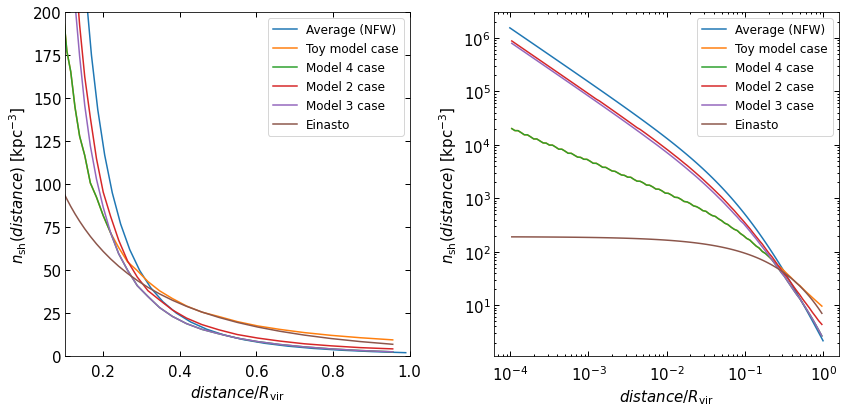

In [8]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,6))

for ax in (ax1,ax2):
    ax.plot(q_list,nsh_list)
    ax.plot(q_toy,nsh_list_toy)
    ax.plot(q_4,nsh_list_4)
    ax.plot(q_2,nsh_list_2)
    ax.plot(q_3,nsh_list_3)
    ax.plot(q_4,einasto(q_4,N=10))
    ax.legend([r'Average (NFW)','Toy model case','Model 4 case',
               'Model 2 case','Model 3 case','Einasto'],fontsize=12)
    ax.set_xlabel(r'$distance/R_{\rm vir}$')
    ax.set_ylabel(r'$n_{\rm sh}(distance)$ [kpc$^{-3}$]')

ax2.set_xscale('log')
ax2.set_yscale('log')
ax1.set_xlim(0.1,1)
ax1.set_ylim(0,200)
plt.tight_layout()
#plt.savefig('num_den_comp.png')

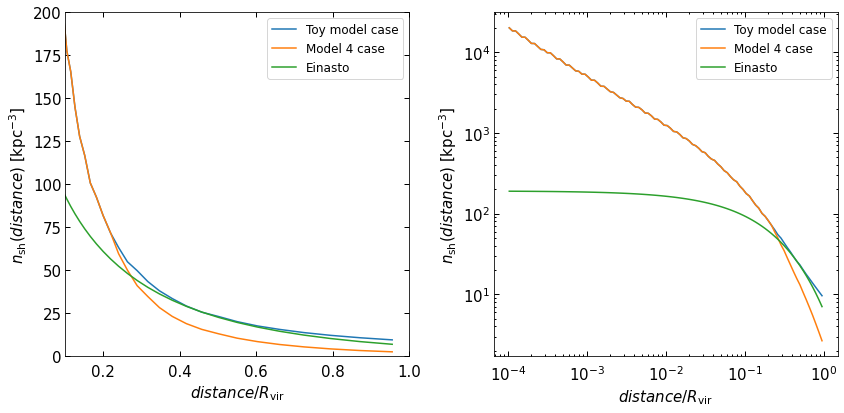

In [9]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,6))

for ax in (ax1,ax2):
    ax.plot(q_toy,nsh_list_toy)
    ax.plot(q_4,nsh_list_4)
    ax.plot(q_4,einasto(q_4,N=10))
    ax.legend(['Toy model case','Model 4 case','Einasto'],fontsize=12)
    ax.set_xlabel(r'$distance/R_{\rm vir}$')
    ax.set_ylabel(r'$n_{\rm sh}(distance)$ [kpc$^{-3}$]')

ax2.set_xscale('log')
ax2.set_yscale('log')
ax1.set_xlim(0.1,1)
ax1.set_ylim(0,200)
plt.tight_layout()
#plt.savefig('num_den_comp_toy_4_02.png')

## Satellites Number, Mass Function, Mass Fraction and Slope Comparison: 

In [10]:
#Satellites Cumulative distribution with Formation condition Vpeak>18 km/s:
def sat_vth(rs0,rhos0,rs_a,rhos_a,Vpeak_max,weight):
    
    rpeak = 2.163*rs_a
    rmax  = 2.163*rs0
    Vpeak = np.sqrt(4.*np.pi*G*rhos_a/4.625)*rs_a
    Vmax  = np.sqrt(4.*np.pi*G*rhos0/4.625)*rs0
    N,x_edges = np.histogram(Vmax[Vpeak>Vpeak_max*km/s]/(km/s),weights=weight[Vpeak>Vpeak_max*km/s],bins=10000)
    x = (x_edges[1:]+x_edges[:-1])/2.
    Ncum = np.cumsum(N)
    Ncum = Ncum[-1]-Ncum

    return Ncum[0], x, Ncum

#Mass Function:
def m2dndm(m0,weight):
    N,lnm_edges = np.histogram(np.log(m0/Msolar),weights=weight)#,bins=100)
    lnm = (lnm_edges[1:]+lnm_edges[:-1])/2.
    dlnm = lnm_edges[1:]-lnm_edges[:-1]

    m = np.exp(lnm)
    dNdlnm = N/dlnm

    dNdm   = dNdlnm/m
    

    return m, m**2*dNdm

m_toy,m2dndm_toy = m2dndm(halos_toy['m0'],halos_toy['weight'])
m_4,m2dndm_4 = m2dndm(halos_4['m0'],halos_4['weight'])
m_2,m2dndm_2 = m2dndm(halos_2['m0'],halos_2['weight'])
m_3,m2dndm_3 = m2dndm(halos_3['m0'],halos_3['weight'])
m_av,m2dndm_av = m2dndm(halos_av['m0'],halos_av['weight'])

In [11]:
Vpeak_max = 18 # km/s

Nsat_tot_toy, V_toy, Nsh_toy = sat_vth(halos_toy['rs0'],halos_toy['rhos0'],halos_toy['rs_a'],
                                       halos_toy['rhos_a'],Vpeak_max,halos_toy['weight'])

Nsat_tot_4, V_4, Nsh_4 = sat_vth(halos_4['rs0'],halos_4['rhos0'],halos_4['rs_a'],
                                       halos_4['rhos_a'],Vpeak_max,halos_4['weight'])

Nsat_tot_2, V_2, Nsh_2 = sat_vth(halos_toy['rs0'],halos_2['rhos0'],halos_2['rs_a'],
                                       halos_2['rhos_a'],Vpeak_max,halos_2['weight'])

Nsat_tot_3, V_3, Nsh_3 = sat_vth(halos_3['rs0'],halos_3['rhos0'],halos_3['rs_a'],
                                       halos_3['rhos_a'],Vpeak_max,halos_3['weight'])

Nsat_tot_av, V_av, Nsh_av = sat_vth(halos_av['rs0'],halos_av['rhos0'],halos_av['rs_a'],
                                       halos_av['rhos_a'],Vpeak_max,halos_av['weight'])

print("Total number of satellites (no spatial) = ", int(Nsat_tot_av))
print("Total number of satellites (with spatial information) model 2 case = ", int(Nsat_tot_2))
print("Total number of satellites (with spatial information) model 3 case = ", int(Nsat_tot_3))
print("Total number of satellites (with spatial information) toy model case = ", int(Nsat_tot_toy))
print("Total number of satellites (with spatial information) model 4 case = ", int(Nsat_tot_4))

Total number of satellites (no spatial) =  81
Total number of satellites (with spatial information) model 2 case =  80
Total number of satellites (with spatial information) model 3 case =  81
Total number of satellites (with spatial information) toy model case =  81
Total number of satellites (with spatial information) model 4 case =  81


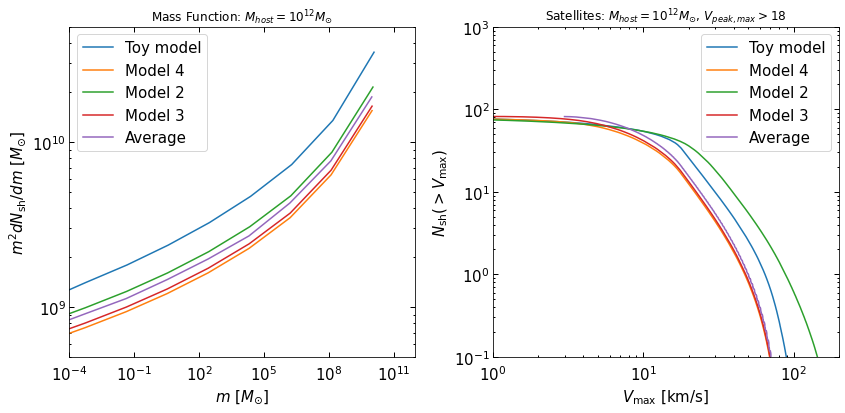

In [12]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,6))
ax1.plot(m_toy,m2dndm_toy)
ax1.plot(m_4,m2dndm_4)
ax1.plot(m_2,m2dndm_2)
ax1.plot(m_3,m2dndm_3)
ax1.plot(m_av,m2dndm_av)
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_title('Mass Function: $M_{host}=10^{ %i } M_{\odot}$' %np.log10(M0),loc='center',fontsize=12)
ax1.set_xlabel(r'$m$ [$M_{\odot}$]')
ax1.set_ylabel(r'$m^{2} dN_{\rm sh}/dm$ [$M_{\odot}$]')
ax1.set_xlim(1e-4,1e12)
ax1.set_ylim(5e8,5e10)

ax2.loglog(V_toy,Nsh_toy)
ax2.loglog(V_4,Nsh_4)
ax2.loglog(V_2,Nsh_2)
ax2.loglog(V_3,Nsh_3)
ax2.loglog(V_av,Nsh_av)
ax2.set_xlim(1,2e2)
ax2.set_ylim(1e-1,1e3)
ax2.set_title('Satellites: $M_{host}=10^{ %i } M_{\odot}$' %np.log10(M0) + 
              str(r', $V_{peak,max}>$') + str(Vpeak_max),loc='center',fontsize=12)
ax2.set_xlabel(r'$V_{\rm max}$ [km/s]')
ax2.set_ylabel(r'$N_{\rm sh}(>V_{\rm max})$')

for ax in (ax1,ax2):
    ax.legend([r'Toy model','Model 4','Model 2','Model 3',r'Average'])
plt.tight_layout()
#plt.savefig('gen_comp.png')

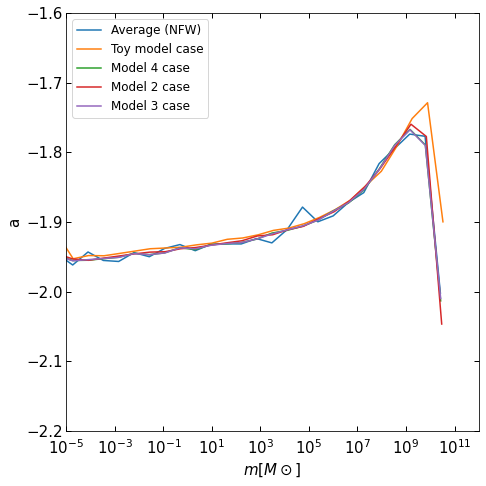

In [13]:
def slope_1(m0,weight):
    N,lnm_edges = np.histogram(np.log(m0/Msolar),weights=weight,bins=30)
    lnm = (lnm_edges[1:]+lnm_edges[:-1])/2.
    dlnm = lnm_edges[1:]-lnm_edges[:-1]
    dlnm_2 = (dlnm[1:]+dlnm[:-1])/2
    m = np.exp(lnm)
    m_2 = (m[1:]+m[:-1])/2.
    dNdm = N/dlnm/m
    dNdm_2= np.log(dNdm[1:])-np.log(dNdm[:-1])
    return m_2,dNdm_2/dlnm_2

m2_av, a_av = slope_1(halos_av['m0'],halos_av['weight'])
m2_toy, a_toy = slope_1(halos_toy['m0'],halos_toy['weight'])
m2_4, a_4 = slope_1(halos_4['m0'],halos_4['weight'])
m2_2, a_2 = slope_1(halos_2['m0'],halos_2['weight'])
m2_3, a_3 = slope_1(halos_3['m0'],halos_3['weight'])


plt.figure(figsize=(7,7))
plt.plot(m2_av, a_av)
plt.plot(m2_toy, a_toy)
plt.plot(m2_4, a_4)
plt.plot(m2_2, a_2)
plt.plot(m2_3, a_3)
plt.xlim(1e-5,1e12)
plt.ylim(-2.2,-1.6)
plt.xscale('log')
plt.xlabel(r"$m[M\odot]$")
plt.ylabel("a")
plt.legend([r'Average (NFW)','Toy model case','Model 4 case','Model 2 case','Model 3 case'],fontsize=12)
#plt.title('Slope: $M_{host}=10^{ %i } M_{\odot}$' %np.log10(M0),loc='center')
plt.tight_layout()
#plt.savefig('slope.png')
plt.show()

In [14]:
import scipy.integrate as spint
def mass_fraction(mass,weight ,Mhost=M0,evolved=True):
    Mhost=Mhost*Msolar
    if evolved:
        fsh = np.sum(mass*weight)/Mhost
    else:
        fsh = np.sum(mass*weight)/Mhost
    return fsh

def mass_fraction_2(mass,weight,Mhost=M0):
    Mhost=Mhost*Msolar
    N,lnm_edges = np.histogram(np.log(mass/Msolar),weights=weight,bins=100)
    lnm = (lnm_edges[1:]+lnm_edges[:-1])/2.
    dlnm = lnm_edges[1:]-lnm_edges[:-1]
    m = np.exp(lnm)
    dNdm = N/dlnm/m
    
    fsh=spint.simpson(dNdm*m,m)/M0
    return fsh

print(" Weighted Sum Calculation:")
print(" Substructure mass fraction for toy model case:",
      mass_fraction(mass=halos_toy['m0'],weight=halos_toy['weight'],Mhost=M0))

print(" Substructure mass fraction for model without spatial information:",
      mass_fraction(mass=halos_av['m0'],weight=halos_av['weight'],Mhost=M0))

print(" Substructure mass fraction for model 4 case:",
      mass_fraction(mass=halos_4['m0'],weight=halos_4['weight'],Mhost=M0))

print(" Substructure mass fraction for model 2 case:",
      mass_fraction(mass=halos_2['m0'],weight=halos_2['weight'],Mhost=M0))

print(" Substructure mass fraction for model 3 case:",
      mass_fraction(mass=halos_3['m0'],weight=halos_3['weight'],Mhost=M0))

print("\n _________________________________________________________________________________ \n")
print(" Integral Calculation:")
print(" Substructure mass fraction for toy model case:",
      mass_fraction_2(mass=halos_toy['m0'],weight=halos_toy['weight'],Mhost=M0))

print(" Substructure mass fraction for model without spatial information:",
      mass_fraction_2(mass=halos_av['m0'],weight=halos_av['weight'],Mhost=M0))

print(" Substructure mass fraction for model 4 case:",
      mass_fraction_2(mass=halos_4['m0'],weight=halos_4['weight'],Mhost=M0))

print(" Substructure mass fraction for model 2 case:",
      mass_fraction_2(mass=halos_2['m0'],weight=halos_2['weight'],Mhost=M0))

print(" Substructure mass fraction for model 3 case:",
      mass_fraction_2(mass=halos_3['m0'],weight=halos_3['weight'],Mhost=M0))

 Weighted Sum Calculation:
 Substructure mass fraction for toy model case: 0.18680923043659228
 Substructure mass fraction for model without spatial information: 0.10057009224411294
 Substructure mass fraction for model 4 case: 0.08253507717359518
 Substructure mass fraction for model 2 case: 0.11262476179548067
 Substructure mass fraction for model 3 case: 0.0879346061942218

 _________________________________________________________________________________ 

 Integral Calculation:
 Substructure mass fraction for toy model case: 0.18462721877825441
 Substructure mass fraction for model without spatial information: 0.09928509327246175
 Substructure mass fraction for model 4 case: 0.08164151481716284
 Substructure mass fraction for model 2 case: 0.11170869038313694
 Substructure mass fraction for model 3 case: 0.08694568349982945
